C:\Users\SIU856526097\AppData\Local\anaconda3\envs\torch_quant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Batch  1 | Acc: 62.0% | Time: 17.4s 
Batch  4 | Acc: 62.0% | Time: 18.8s 
Batch  8 | Acc: 62.0% | Time: 15.1s 
Batch 16 | Acc: 62.0% | Time: 14.1s 


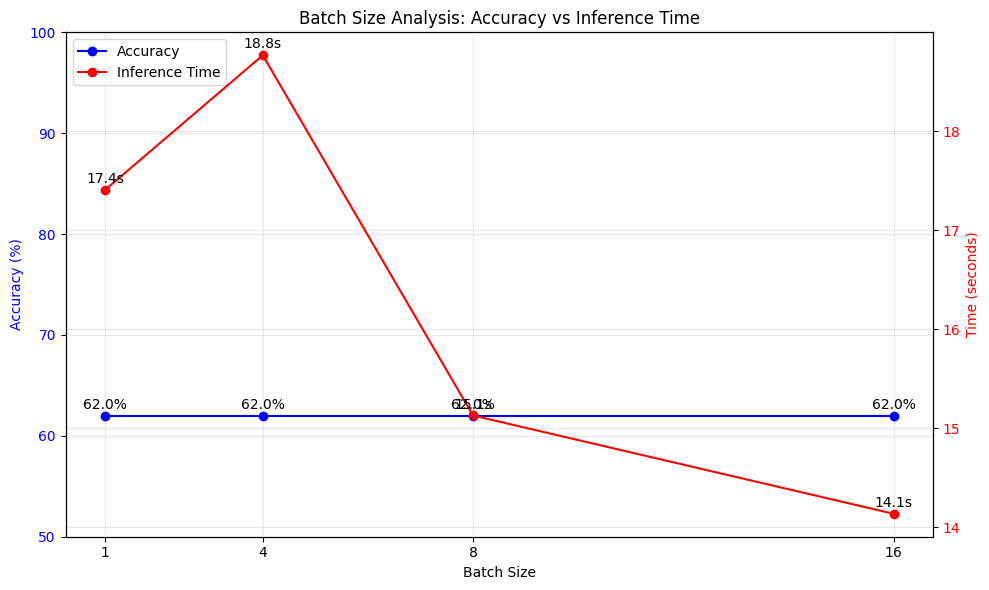

In [1]:
import torch
from torchvision import models, transforms
import os
from PIL import Image
import time
import gc
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Configuration
val_root = 'C:/Users/SIU856526097/datasets/val_images/val'
class_folders = sorted(os.listdir(val_root))[:500]  # Use 500 classes
batch_sizes = [1, 4, 8, 16]
results = {'batch_size': [], 'accuracy': [], 'time': [], 'speed': []}

# Model setup
torch.backends.quantized.engine = 'none'
torch.set_num_threads(2)
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Conv2d}, dtype=torch.qint8
).eval()

# Dataset class
class ImageNetValDataset(Dataset):
    def __init__(self, root, folders, transform=None):
        self.root = root
        self.folders = folders
        self.transform = transform
        self.image_paths = []
        
        for class_idx, folder in enumerate(folders):
            folder_path = os.path.join(root, folder)
            try:
                img_file = next(f for f in os.listdir(folder_path) 
                              if f.lower().endswith(('.jpg','.jpeg','.png')))
                self.image_paths.append((os.path.join(folder_path, img_file), class_idx))
            except:
                continue

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), label

# Transform
transform = transforms.Compose([
    transforms.Resize(160),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Evaluation function
def evaluate_batch(batch_size):
    dataset = ImageNetValDataset(val_root, class_folders, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    correct = 0
    total = 0
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    total_time = time.time() - start_time
    accuracy = 100 * correct / total
     
    results['batch_size'].append(batch_size)
    results['accuracy'].append(accuracy)
    results['time'].append(total_time)
    
    print(f"Batch {batch_size:2d} | Acc: {accuracy:.1f}% | Time: {total_time:.1f}s ")

# Run evaluation for all batch sizes
for bs in batch_sizes:
    gc.collect()
    evaluate_batch(bs)


plt.figure(figsize=(10, 6))

# Plot Accuracy (left axis)
ax1 = plt.gca()  # Get current axis
ax1.plot(results['batch_size'], results['accuracy'], 'bo-', label='Accuracy')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Accuracy (%)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylim(50, 100)  # Set appropriate accuracy range
ax1.grid(True, alpha=0.3)

# Create second y-axis for Inference Time
ax2 = ax1.twinx()
ax2.plot(results['batch_size'], results['time'], 'ro-', label='Inference Time')
ax2.set_ylabel('Time (seconds)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Batch Size Analysis: Accuracy vs Inference Time')
plt.xticks(results['batch_size'])  # Show all tested batch sizes
plt.grid(True, alpha=0.3)

# Annotate data points
for bs, acc, t in zip(results['batch_size'], results['accuracy'], results['time']):
    ax1.annotate(f'{acc:.1f}%', (bs, acc), textcoords="offset points", xytext=(0,5), ha='center')
    ax2.annotate(f'{t:.1f}s', (bs, t), textcoords="offset points", xytext=(0,5), ha='center')  # Fixed variable name

plt.tight_layout()
plt.savefig('batch_size_analysis_combined.png', dpi=300, bbox_inches='tight')
plt.show()



Preparing quantized model...


C:\Users\SIU856526097\AppData\Local\anaconda3\envs\torch_quant1\lib\site-packages\torch\ao\quantization\fx\prepare.py:1530: UserWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping instead.
  warnings.warn(


Static quantization complete!

Starting evaluation...
Batch  1 | Acc: 67.8% | Time: 37.64s
Batch  4 | Acc: 67.8% | Time: 29.49s
Batch  8 | Acc: 67.8% | Time: 28.21s
Batch 16 | Acc: 67.8% | Time: 31.50s


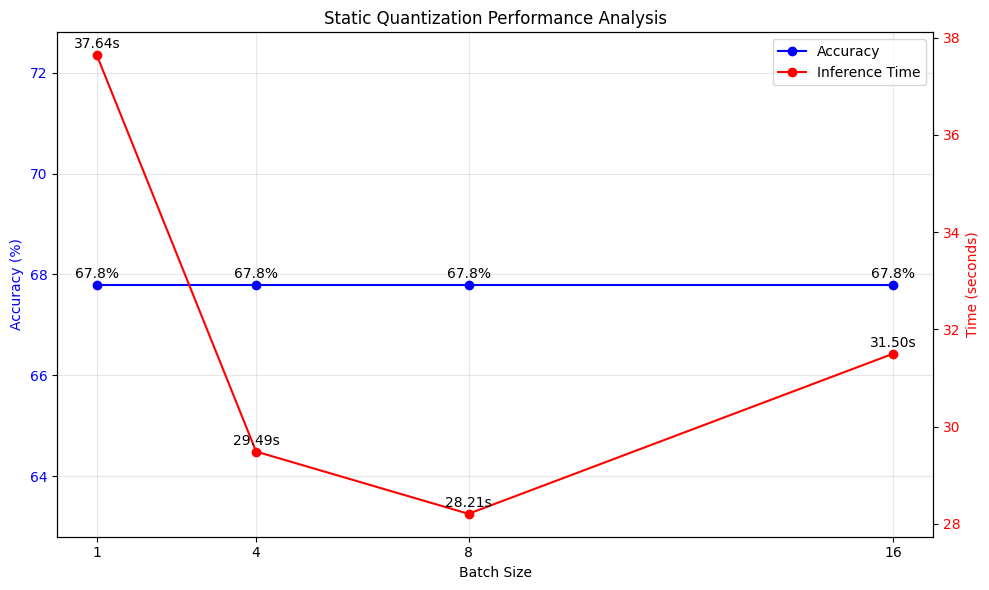

In [1]:
import torch
from torchvision import models, transforms
import os
from PIL import Image
import time
import gc
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.ao.quantization import QConfig, MinMaxObserver, HistogramObserver, quantize_fx

# Configuration
val_root = 'C:/Users/SIU856526097/datasets/val_images/val'
class_folders = sorted(os.listdir(val_root))[:500]  # Use 500 classes
batch_sizes = [1, 4, 8, 16]
results = {'batch_size': [], 'accuracy': [], 'time': []}

# Static Quantization with Compatible Configuration
def prepare_static_quant_model():
    # Load model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).eval()
    
    # Use per-tensor quantization for compatibility
    qconfig = QConfig(
        activation=HistogramObserver.with_args(
            dtype=torch.quint8,
            reduce_range=False
        ),
        weight=MinMaxObserver.with_args(
            dtype=torch.qint8,
            qscheme=torch.per_tensor_symmetric  # Changed from per_channel
        )
    )
    
    # Prepare model for quantization
    model_prepared = quantize_fx.prepare_fx(
        model,
        {"": qconfig},
        example_inputs=torch.randn(1, 3, 128, 128)
    )
    
    # Calibrate with real data (1 batch)
    transform = transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    calib_dataset = ImageNetValDataset(val_root, class_folders[:50], transform)
    calib_loader = DataLoader(calib_dataset, batch_size=32, shuffle=True)
    
    with torch.no_grad():
        for inputs, _ in calib_loader:
            model_prepared(inputs)
            break  # Use just 1 batch
    
    # Convert to quantized model
    model_quantized = quantize_fx.convert_fx(model_prepared)
    
    return model_quantized

# Dataset class
class ImageNetValDataset(Dataset):
    def __init__(self, root, folders, transform=None):
        self.root = root
        self.folders = folders
        self.transform = transform
        self.image_paths = []
        
        for class_idx, folder in enumerate(folders):
            folder_path = os.path.join(root, folder)
            try:
                img_file = next(f for f in os.listdir(folder_path) 
                              if f.lower().endswith(('.jpg','.jpeg','.png')))
                self.image_paths.append((os.path.join(folder_path, img_file), class_idx))
            except:
                continue

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), label

# Evaluation function
def evaluate_batch(batch_size):
    transform = transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    dataset = ImageNetValDataset(val_root, class_folders, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Warmup
    with torch.no_grad():
        for inputs, _ in loader:
            _ = model(inputs)
            break
    
    # Evaluation
    correct = 0
    total = 0
    start_time = time.perf_counter()
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    total_time = time.perf_counter() - start_time
    accuracy = 100 * correct / total if total > 0 else 0
    
    results['batch_size'].append(batch_size)
    results['accuracy'].append(accuracy)
    results['time'].append(total_time)
    
    print(f"Batch {batch_size:2d} | Acc: {accuracy:.1f}% | Time: {total_time:.2f}s")

# Main execution
if __name__ == "__main__":
    print("Preparing quantized model...")
    model = prepare_static_quant_model()
    print("Static quantization complete!\n")
    
    print("Starting evaluation...")
    for bs in batch_sizes:
        gc.collect()
        evaluate_batch(bs)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax1.plot(results['batch_size'], results['accuracy'], 'bo-', label='Accuracy')
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Accuracy (%)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(max(0, min(results['accuracy'])-5), min(100, max(results['accuracy'])+5))
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(results['batch_size'], results['time'], 'ro-', label='Inference Time')
    ax2.set_ylabel('Time (seconds)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.title('Static Quantization Performance Analysis')
    plt.xticks(results['batch_size'])

    for bs, acc, t in zip(results['batch_size'], results['accuracy'], results['time']):
        ax1.annotate(f'{acc:.1f}%', (bs, acc), textcoords="offset points", xytext=(0,5), ha='center')
        ax2.annotate(f'{t:.2f}s', (bs, t), textcoords="offset points", xytext=(0,5), ha='center')

    plt.tight_layout()
    plt.savefig('static_quant_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

Preparing quantized model...
Static quantization complete!

Starting evaluation...
Batch  1 | Acc: 64.0% | Time: 65.95s
Batch  4 | Acc: 64.0% | Time: 53.40s
Batch  8 | Acc: 64.0% | Time: 49.37s
Batch 16 | Acc: 64.0% | Time: 47.68s


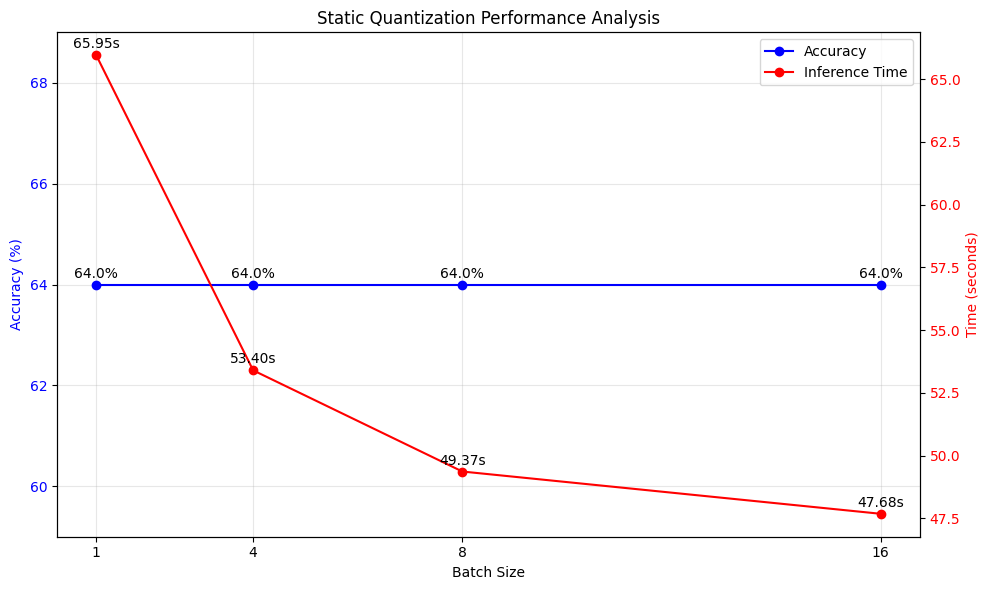

In [2]:
import torch
from torchvision import models, transforms
import os
from PIL import Image
import time
import gc
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.ao.quantization import QConfig, MinMaxObserver, HistogramObserver, quantize_fx

# Configuration
val_root = 'C:/Users/SIU856526097/datasets/val_images/val'
class_folders = sorted(os.listdir(val_root))[:500]  # Use 500 classes
batch_sizes = [1, 4, 8, 16]
results = {'batch_size': [], 'accuracy': [], 'time': []}

# Static Quantization with Compatible Configuration
def prepare_static_quant_model():
    # Load model
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).eval()
    
    # Use per-tensor quantization for compatibility
    qconfig = QConfig(
        activation=HistogramObserver.with_args(
            dtype=torch.quint8,
            reduce_range=False
        ),
        weight=MinMaxObserver.with_args(
            dtype=torch.qint8,
            qscheme=torch.per_tensor_symmetric  # Changed from per_channel
        )
    )
    
    # Prepare model for quantization
    model_prepared = quantize_fx.prepare_fx(
        model,
        {"": qconfig},
        example_inputs=torch.randn(1, 3, 128, 128)
    )
    
    # Calibrate with real data (1 batch)
    transform = transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    calib_dataset = ImageNetValDataset(val_root, class_folders[:50], transform)
    calib_loader = DataLoader(calib_dataset, batch_size=32, shuffle=True)
    
    with torch.no_grad():
        for inputs, _ in calib_loader:
            model_prepared(inputs)
            break  # Use just 1 batch
    
    # Convert to quantized model
    model_quantized = quantize_fx.convert_fx(model_prepared)
    
    return model_quantized

# Dataset class
class ImageNetValDataset(Dataset):
    def __init__(self, root, folders, transform=None):
        self.root = root
        self.folders = folders
        self.transform = transform
        self.image_paths = []
        
        for class_idx, folder in enumerate(folders):
            folder_path = os.path.join(root, folder)
            try:
                img_file = next(f for f in os.listdir(folder_path) 
                              if f.lower().endswith(('.jpg','.jpeg','.png')))
                self.image_paths.append((os.path.join(folder_path, img_file), class_idx))
            except:
                continue

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), label

# Evaluation function
def evaluate_batch(batch_size):
    transform = transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    dataset = ImageNetValDataset(val_root, class_folders, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) # try num_workers=4 or 8
    
    # Warmup
    with torch.no_grad():
        for inputs, _ in loader:
            _ = model(inputs)
            break
    
    # Evaluation
    correct = 0
    total = 0
    start_time = time.perf_counter()
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    total_time = time.perf_counter() - start_time
    accuracy = 100 * correct / total if total > 0 else 0
    
    results['batch_size'].append(batch_size)
    results['accuracy'].append(accuracy)
    results['time'].append(total_time)
    
    print(f"Batch {batch_size:2d} | Acc: {accuracy:.1f}% | Time: {total_time:.2f}s")

# Main execution
if __name__ == "__main__":
    print("Preparing quantized model...")
    model = prepare_static_quant_model()
    print("Static quantization complete!\n")
    
    print("Starting evaluation...")
    for bs in batch_sizes:
        gc.collect()
        evaluate_batch(bs)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax1.plot(results['batch_size'], results['accuracy'], 'bo-', label='Accuracy')
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Accuracy (%)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(max(0, min(results['accuracy'])-5), min(100, max(results['accuracy'])+5))
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(results['batch_size'], results['time'], 'ro-', label='Inference Time')
    ax2.set_ylabel('Time (seconds)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.title('Static Quantization Performance Analysis')
    plt.xticks(results['batch_size'])

    for bs, acc, t in zip(results['batch_size'], results['accuracy'], results['time']):
        ax1.annotate(f'{acc:.1f}%', (bs, acc), textcoords="offset points", xytext=(0,5), ha='center')
        ax2.annotate(f'{t:.2f}s', (bs, t), textcoords="offset points", xytext=(0,5), ha='center')

    plt.tight_layout()
    plt.savefig('static_quant_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

Preparing quantized model...
Static quantization complete!

GraphModule(
  (conv1): QuantizedConvReLU2d(3, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.013860524632036686, zero_point=0, padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.007492400705814362, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.02426932193338871, zero_point=143, padding=(1, 1))
    )
    (1): Module(
      (conv1): QuantizedConvReLU2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.008330784738063812, zero_point=0, padding=(1, 1))
      (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.030322875827550888, zero_point=155, padding=(1, 1))
    )
  )
  (layer2): Module(
    (0): Module(
      (conv1): QuantizedConvReLU2d(64, 128, kernel_size=(3, 3)

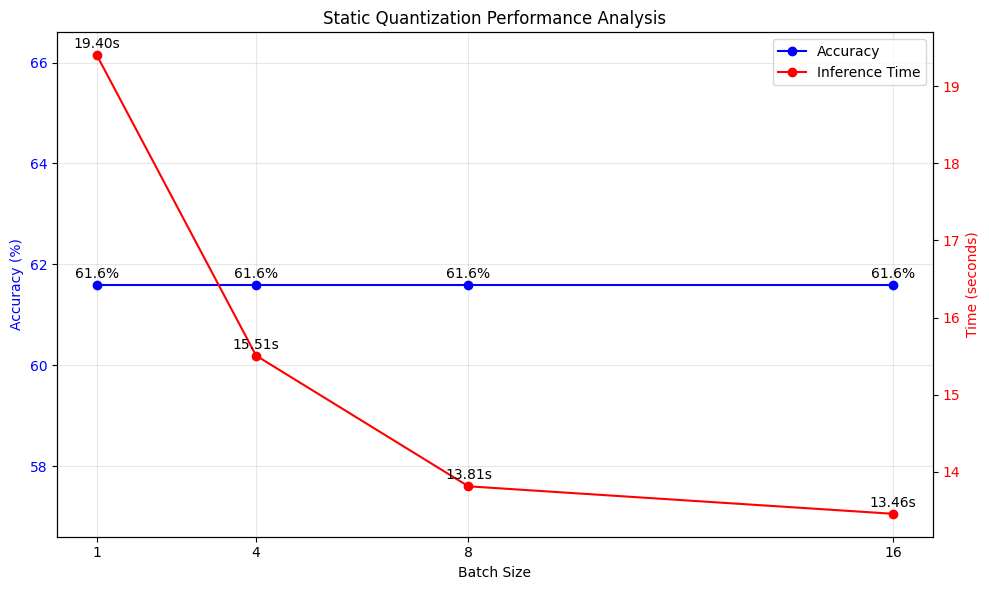

In [6]:
import torch
from torchvision import models, transforms
import os
from PIL import Image
import time
import gc
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.ao.quantization import QConfig, MinMaxObserver, HistogramObserver, quantize_fx
from torch.ao.quantization import (
    get_default_qconfig_mapping,
    QConfigMapping,
    default_histogram_observer,
    MinMaxObserver,
    FixedQParamsObserver
)
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
# Configuration
val_root = 'C:/Users/SIU856526097/datasets/val_images/val'
class_folders = sorted(os.listdir(val_root))[:500]  # Use 500 classes
batch_sizes = [1, 4, 8, 16]
results = {'batch_size': [], 'accuracy': [], 'time': []}

# Static Quantization with Compatible Configuration
def prepare_static_quant_model():
    #model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1).eval()
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).eval()
    #model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1).eval()
    #qconfig_mapping = get_default_qconfig_mapping("x86")
    #qconfig_mapping = get_default_qconfig_mapping("fbgemm")
    qconfig_mapping = get_default_qconfig_mapping("qnnpack")
    model_prepared = prepare_fx(model, qconfig_mapping, example_inputs=torch.randn(1, 3, 224, 224))
    
    # Calibrate with real data (1 batch)
    transform = transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    calib_dataset = ImageNetValDataset(val_root, class_folders[:500], transform)
    calib_loader = DataLoader(calib_dataset, batch_size=32, shuffle=True)
    
    with torch.no_grad():
        for inputs, _ in calib_loader:
            model_prepared(inputs)
            break  # Use just 1 batch
    
    # Convert to quantized model
    model_quantized = quantize_fx.convert_fx(model_prepared)
    
    return model_quantized

# Dataset class
class ImageNetValDataset(Dataset):
    def __init__(self, root, folders, transform=None):
        self.root = root
        self.folders = folders
        self.transform = transform
        self.image_paths = []
        
        for class_idx, folder in enumerate(folders):
            folder_path = os.path.join(root, folder)
            try:
                img_file = next(f for f in os.listdir(folder_path) 
                              if f.lower().endswith(('.jpg','.jpeg','.png')))
                self.image_paths.append((os.path.join(folder_path, img_file), class_idx))
            except:
                continue

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path, label = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), label

# Evaluation function
def evaluate_batch(batch_size):
    transform = transforms.Compose([
        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    dataset = ImageNetValDataset(val_root, class_folders, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) # try num_workers=4 or 8
    
    # Warmup
    with torch.no_grad():
        for inputs, _ in loader:
            _ = model(inputs)
            break
    
    # Evaluation
    correct = 0
    total = 0
    start_time = time.perf_counter()
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    total_time = time.perf_counter() - start_time
    accuracy = 100 * correct / total if total > 0 else 0
    
    results['batch_size'].append(batch_size)
    results['accuracy'].append(accuracy)
    results['time'].append(total_time)
    
    print(f"Batch {batch_size:2d} | Acc: {accuracy:.1f}% | Time: {total_time:.2f}s")

# Main execution
if __name__ == "__main__":
    print("Preparing quantized model...")
    model = prepare_static_quant_model()
    print("Static quantization complete!\n")
    print(model)
    print("Starting evaluation...")
    for bs in batch_sizes:
        gc.collect()
        evaluate_batch(bs)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax1.plot(results['batch_size'], results['accuracy'], 'bo-', label='Accuracy')
    ax1.set_xlabel('Batch Size')
    ax1.set_ylabel('Accuracy (%)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(max(0, min(results['accuracy'])-5), min(100, max(results['accuracy'])+5))
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(results['batch_size'], results['time'], 'ro-', label='Inference Time')
    ax2.set_ylabel('Time (seconds)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.title('Static Quantization Performance Analysis')
    plt.xticks(results['batch_size'])

    for bs, acc, t in zip(results['batch_size'], results['accuracy'], results['time']):
        ax1.annotate(f'{acc:.1f}%', (bs, acc), textcoords="offset points", xytext=(0,5), ha='center')
        ax2.annotate(f'{t:.2f}s', (bs, t), textcoords="offset points", xytext=(0,5), ha='center')

    plt.tight_layout()
    plt.savefig('static_quant_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()